# Score prediction model for animes

In [1]:
## Database 
import warnings
import pandas as pd
import numpy as np

#Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.pylab as pylab
%matplotlib inline
pd.set_option('display.max_columns', 500)
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12, 8

#sklearn packages
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz

from subprocess import call

# Display in jupyter notebook
from IPython.display import Image

#We use KNN again
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

#ignore warnings
warnings.filterwarnings('ignore')


In [2]:
# We restrict the dataset to avoid running out of memory
anime_data = pd.read_csv('../data/raw/anime.csv')
anime_data = anime_data[(anime_data['Type'] == "TV")]
reduced_df = anime_data[['MAL_ID','Name', 'Score', 'Ranked', 'Popularity', 'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped', 'Plan to Watch']]
reduced_df.Score = reduced_df.Score.replace('Unknown', np.nan)
reduced_df.Ranked = reduced_df.Ranked.replace('Unknown', np.nan)
reduced_df.Score = pd.to_numeric(reduced_df.Score)
reduced_df.Ranked = pd.to_numeric(reduced_df.Ranked)
reduced_df.dropna(inplace=True)
reduced_df.reset_index(drop=True, inplace=True)
reduced_df.head(-1)


,MAL_ID,Name,Score,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch
0,1,Cowboy Bebop,8.78,28.0,39,1251960,61971,105808,718161,71513,26678,329800
1,6,Trigun,8.24,266.0,201,558913,12944,29113,343492,25465,13925,146918
2,7,Witch Hunter Robin,7.27,2481.0,1467,94683,587,4300,46165,5121,5378,33719
3,8,Bouken Ou Beet,6.98,3710.0,4369,13224,18,642,7314,766,1108,3394
4,15,Eyeshield 21,7.95,604.0,1003,148259,2066,13907,78349,14228,11573,30202
...,...,...,...,...,...,...,...,...,...,...,...,...
3831,44040,Abciee Shuugyou Nikki,5.32,10102.0,9713,1413,2,832,2,40,269,270
3832,44044,Jimihen!!: Jimiko wo Kaechau Jun Isei Kouyuu!!,6.12,7726.0,3876,17613,194,5996,0,467,659,10491
3833,44208,Yami Shibai 8,6.09,7853.0,6210,5556,14,2511,3,103,119,2820
3834,44235,Pui Pui Molcar,8.33,206.0,7521,3418,73,2624,0,48,108,638


In [3]:
reduced_df.describe()

,MAL_ID,Score,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch
count,3837.000000,3837.000000,3837.000000,3837.000000,3.837000e+03,3837.000000,3837.000000,3.837000e+03,3837.00000,3837.000000,3837.000000
mean,15582.937972,6.894178,4329.639302,4180.978108,1.184188e+05,1842.171488,8968.791764,7.415273e+04,3822.94136,4864.358614,26610.010685
std,14693.799122,0.789870,2854.059824,3516.096600,2.366797e+05,8341.528748,28920.615466,1.740272e+05,8476.20880,9194.192926,41914.946656
min,1.000000,2.180000,1.000000,1.000000,3.230000e+02,0.000000,9.000000,0.000000e+00,4.00000,16.000000,49.000000
25%,2280.000000,6.390000,1867.000000,1208.000000,4.644000e+03,11.000000,261.000000,1.574000e+03,200.00000,298.000000,1737.000000
50%,9241.000000,6.890000,4075.000000,3143.000000,2.719100e+04,83.000000,1643.000000,1.173400e+04,1040.00000,1530.000000,8685.000000
75%,31764.000000,7.410000,6474.000000,6685.000000,1.216410e+05,603.000000,7765.000000,6.359200e+04,4114.00000,5870.000000,33037.000000
max,46118.000000,9.190000,11073.000000,13258.000000,2.589552e+06,183914.000000,887333.000000,2.182587e+06,187919.00000,174710.000000,425531.000000


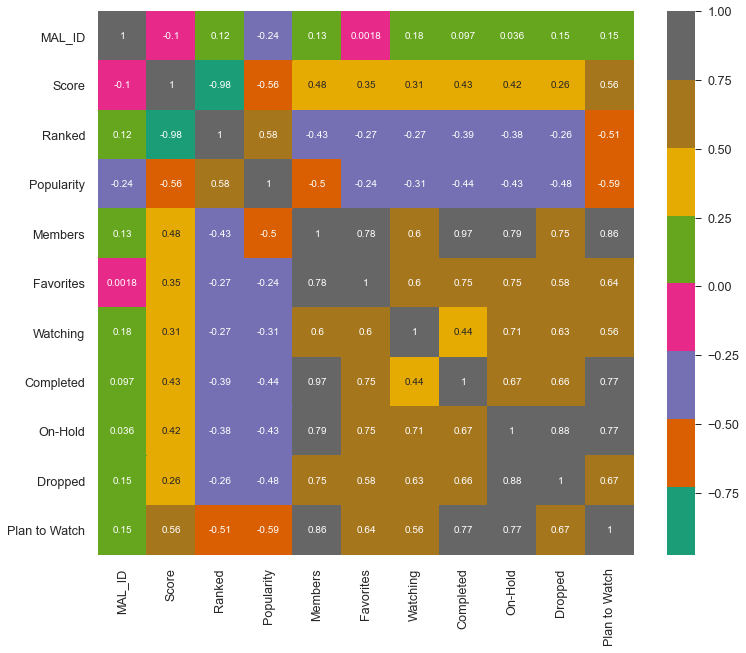

In [4]:
plt.figure(figsize=(12,10))
cor = reduced_df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Dark2)
plt.show()


<AxesSubplot:xlabel='Score', ylabel='Density'>

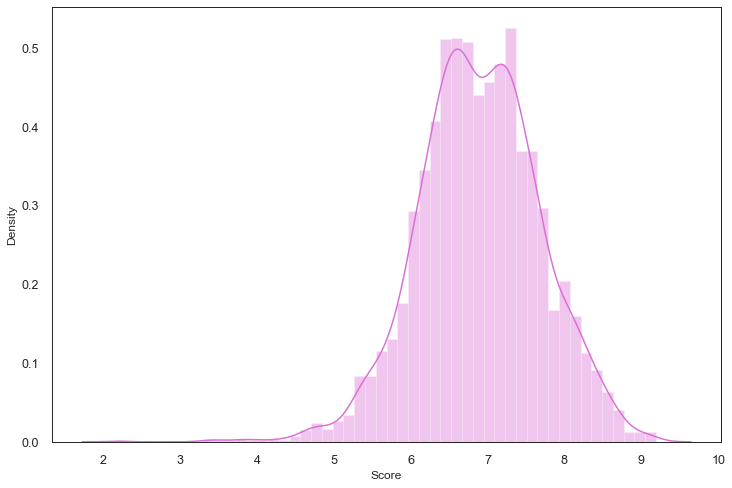

In [5]:
sns.distplot(reduced_df['Score'], color="orchid")

In [6]:
scaler = StandardScaler(copy=True)

reduced_df.Score = pd.DataFrame(scaler.fit_transform(
    pd.DataFrame(reduced_df["Score"])), columns=["Score"])


<AxesSubplot:xlabel='Score', ylabel='Density'>

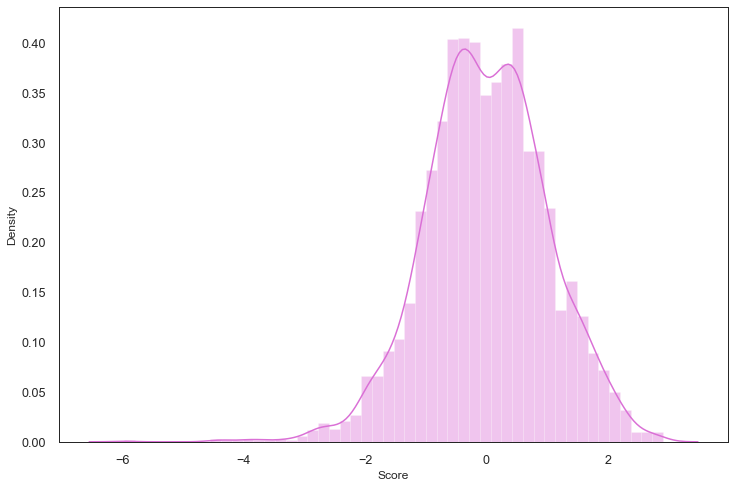

In [7]:
sns.distplot(reduced_df['Score'], color="orchid")


In [8]:
reduced_df['Rating category'] = pd.cut(reduced_df.Score, bins=[-10, -1.3, -0.5, 0, 0.5, 1.3, 10], labels=[-3,-2,-1,1,2,3 ])


<AxesSubplot:>

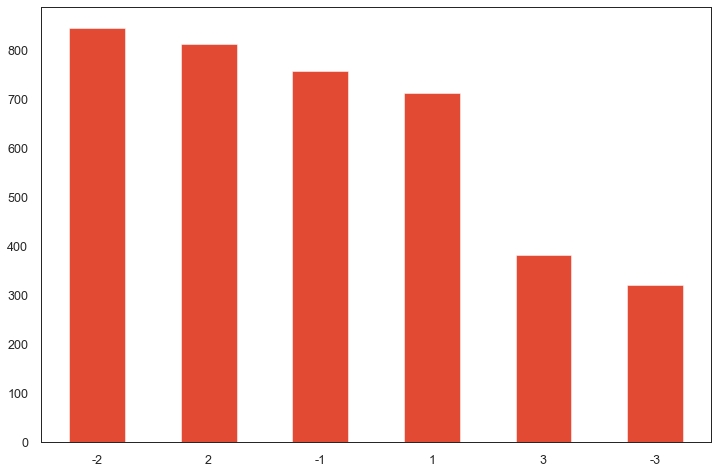

In [9]:
reduced_df['Rating category'].value_counts().plot.bar(rot=0)


In [29]:
features = reduced_df[['Ranked', 'Popularity', 'Members', 'Favorites',
                       'Watching', 'Completed', 'On-Hold', 'Dropped', 'Plan to Watch']].copy()
labels = reduced_df['Rating category']

## Train — test
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.4, random_state=42)



In [30]:
def print_results(results):
  print('BEST PARAMS: {}\n'.format(results.best_params_))
  means = results.cv_results_['mean_test_score']
  stds = results.cv_results_['std_test_score']
  for mean, std, params in zip(means, stds, results.cv_results_['params']):
    print('{}(+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))



rf = RandomForestClassifier()
parameters = {'n_estimators': [50, 100],
              'max_depth': [10, 20, None]
              }
rf_cv = GridSearchCV(rf, parameters, cv=5)
rf_cv.fit(X_train, y_train.values.ravel())
print_results(rf_cv)




BEST PARAMS: {'max_depth': 20, 'n_estimators': 100}

0.995(+/-0.004) for {'max_depth': 10, 'n_estimators': 50}
0.994(+/-0.004) for {'max_depth': 10, 'n_estimators': 100}
0.995(+/-0.005) for {'max_depth': 20, 'n_estimators': 50}
0.995(+/-0.006) for {'max_depth': 20, 'n_estimators': 100}
0.995(+/-0.004) for {'max_depth': None, 'n_estimators': 50}
0.995(+/-0.006) for {'max_depth': None, 'n_estimators': 100}


In [31]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=20)
rf_model.fit(X_train, y_train)
rf_predicted_values = rf_model.predict(X_test)
score = accuracy_score(y_test, rf_predicted_values)
print(score)


0.9947882736156352


In [32]:
for name, importance in zip(features.columns, rf_model.feature_importances_):  
  print(name, "=", importance)


Ranked = 0.7347894894498074
Popularity = 0.021394195065810234
Members = 0.024719981175883532
Favorites = 0.08639705676523546
Watching = 0.017387880836573274
Completed = 0.01987309273568681
On-Hold = 0.024877723794947376
Dropped = 0.03879717991291672
Plan to Watch = 0.03176340026313922


In [33]:
tree = rf_model.estimators_[5]
export_graphviz(tree,
 feature_names=features.columns,
 out_file='rf_anime_tree.dot',
 filled=True,
 rounded=True)
 


In [34]:
import pydot

(graph,) = pydot.graph_from_dot_file('rf_anime_tree.dot')
graph.write_png('tree.png')


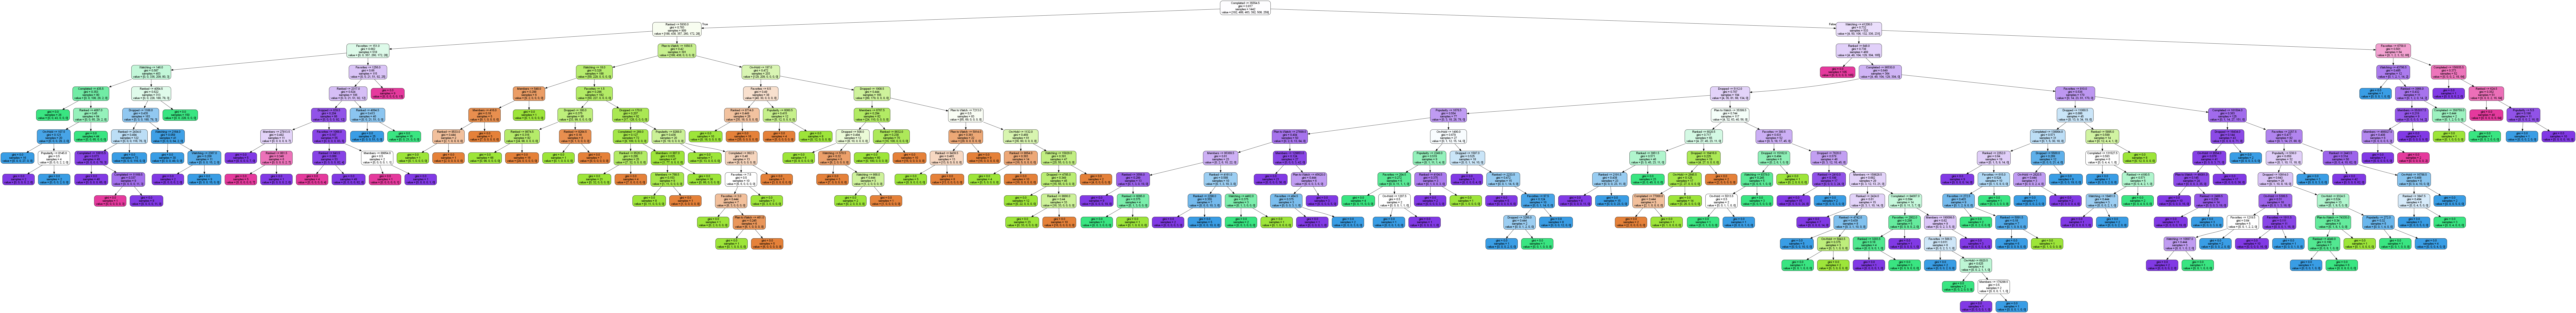

In [35]:
# Display in jupyter notebook
from IPython.display import Image
Image(filename='tree.png')
